In [1766]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
import numpy as np
#import pgeocode as pg
import seaborn as sns
import openpyxl

# Load zipcodes files

In [1767]:
#zipcodes = gpd.read_file('data/zipcodes.geojson')
#print(zipcodes.crs)
#zipcodes.head()

In [1768]:
#drop po_name so can load specific location data in
#zipcodes=zipcodes[['zip','objectid','shape_stlength','shape_starea','geometry']]
#zipcodes.head()

In [1769]:
#leg_kwds = {'title': 'Zipcodes', 'loc': 'upper left', 
#           'bbox_to_anchor': (1, 1.03), 'ncol': 2}

#zipcodes.plot(column = 'zip', figsize=(10, 10),
#              edgecolor = 'black',
#              legend = True, legend_kwds = leg_kwds, 
#              cmap = 'Set2')
#plt.show()

# Load Data files

In [1770]:
V_protocol = pd.read_csv('data/vaccine_with_protocol.csv')
C_count = pd.read_csv('data/COVID_CountByZipPerDate 03292021.csv')
zip_hood=pd.read_csv('data/neighborhoods.csv')

###  Review data

In [1771]:
print(V_protocol.shape)
V_protocol.head()

(6694, 5)


,vacc_date,zipcode,count_given,dose_nbr,protocol
0,2020-12-12,37215.0,1.0,1.0,two-shot
1,2020-12-14,37205.0,1.0,2.0,two-shot
2,2020-12-14,37215.0,1.0,1.0,two-shot
3,2020-12-15,37221.0,1.0,1.0,two-shot
4,2020-12-16,37215.0,1.0,1.0,two-shot


In [1772]:
print(C_count.shape)
C_count.head()

(8832, 3)


,Specimen Collection Date,Zip,Cases
0,3/6/2020,37217.0,1
1,3/10/2020,37214.0,1
2,3/11/2020,37013.0,1
3,3/11/2020,37204.0,2
4,3/11/2020,37205.0,1


In [1773]:
C_count=C_count.dropna()
C_count.head()

,Specimen Collection Date,Zip,Cases
0,3/6/2020,37217.0,1
1,3/10/2020,37214.0,1
2,3/11/2020,37013.0,1
3,3/11/2020,37204.0,2
4,3/11/2020,37205.0,1


In [1774]:
zip_hood.head()

,zip,neighborhood,neighborhood2
0,37013,Antioch,Antioch
1,37027,Brentwood,Brentwood
2,37069,Franklin,Franklin
3,37072,Goodlettesville,Goodlettesville | Parkwood
4,37076,South Hermitage,South Hermitage


In [1775]:
#Dropping NA
V_protocol=V_protocol.dropna()
V_protocol.head()

,vacc_date,zipcode,count_given,dose_nbr,protocol
0,2020-12-12,37215.0,1.0,1.0,two-shot
1,2020-12-14,37205.0,1.0,2.0,two-shot
2,2020-12-14,37215.0,1.0,1.0,two-shot
3,2020-12-15,37221.0,1.0,1.0,two-shot
4,2020-12-16,37215.0,1.0,1.0,two-shot


### Rename Column Headers

In [1776]:
V_protocol=V_protocol.rename(columns={'vacc_date':'date','count_given':'vaccines','dose_nbr':'dose'})
V_protocol.head()

,date,zipcode,vaccines,dose,protocol
0,2020-12-12,37215.0,1.0,1.0,two-shot
1,2020-12-14,37205.0,1.0,2.0,two-shot
2,2020-12-14,37215.0,1.0,1.0,two-shot
3,2020-12-15,37221.0,1.0,1.0,two-shot
4,2020-12-16,37215.0,1.0,1.0,two-shot


In [1777]:
C_count=C_count.rename(columns={'Specimen Collection Date':'date','Zip':'zipcode'})
C_count.head()

,date,zipcode,Cases
0,3/6/2020,37217.0,1
1,3/10/2020,37214.0,1
2,3/11/2020,37013.0,1
3,3/11/2020,37204.0,2
4,3/11/2020,37205.0,1


# Change zip to int then to str

In [1778]:
#changing zip to int then to str
C_count.zipcode = C_count.zipcode.astype('Int64')
V_protocol.zipcode = V_protocol.zipcode.astype('Int64')
zip_hood.zip=zip_hood.zip.astype('str')

In [1779]:
zip_hood.dtypes

zip              object
neighborhood     object
neighborhood2    object
dtype: object

In [1780]:
#C_count.zipcode = C_count.zipcode.astype('str')
#V_protocol.zipcode = V_protocol.zipcode.astype('str')
#Ethnicity_df.Zipcode =  Ethnicity_df.Zipcode.astype('str')

# Group by zipcode

In [1781]:
#group by zipcode to get total cases per zipcode and drop null
Covid_df2 = C_count.groupby(['zipcode'],as_index=False)['Cases'].sum()
Covid_df2=Covid_df2.dropna()
Covid_df2.head()


,zipcode,Cases
0,37013,13354
1,37027,231
2,37069,16
3,37072,2984
4,37076,4279


# Basing on one dose vaccine, extracting one dose only

In [1782]:
V_protocol=V_protocol[V_protocol['dose']==1]
V_protocol.head()

,date,zipcode,vaccines,dose,protocol
0,2020-12-12,37215,1.0,1.0,two-shot
2,2020-12-14,37215,1.0,1.0,two-shot
3,2020-12-15,37221,1.0,1.0,two-shot
4,2020-12-16,37215,1.0,1.0,two-shot
5,2020-12-17,37013,16.0,1.0,two-shot


In [1783]:
V_protocol = V_protocol.groupby(['zipcode'],as_index=False)['vaccines'].sum()

V_protocol.head()

,zipcode,vaccines
0,37013,18465.0
1,37027,352.0
2,37069,50.0
3,37072,8460.0
4,37076,11113.0


### Merging cases with vaccine  V_protocol and Covid-df2

In [1784]:
Cases_Vacc=pd.merge(Covid_df2,V_protocol, how='inner',on='zipcode')
Cases_Vacc.head()

,zipcode,Cases,vaccines
0,37013,13354,18465.0
1,37027,231,352.0
2,37069,16,50.0
3,37072,2984,8460.0
4,37076,4279,11113.0


In [1785]:
Cases_Vacc =Cases_Vacc.sort_values('vaccines', ascending=False)
Cases_Vacc.head()

,zipcode,Cases,vaccines
18,37211,10233,19175.0
0,37013,13354,18465.0
28,37221,3910,17222.0
12,37205,2566,14666.0
16,37209,5072,13600.0


Text(0.5, 1.0, 'Vaccines by zipcode')

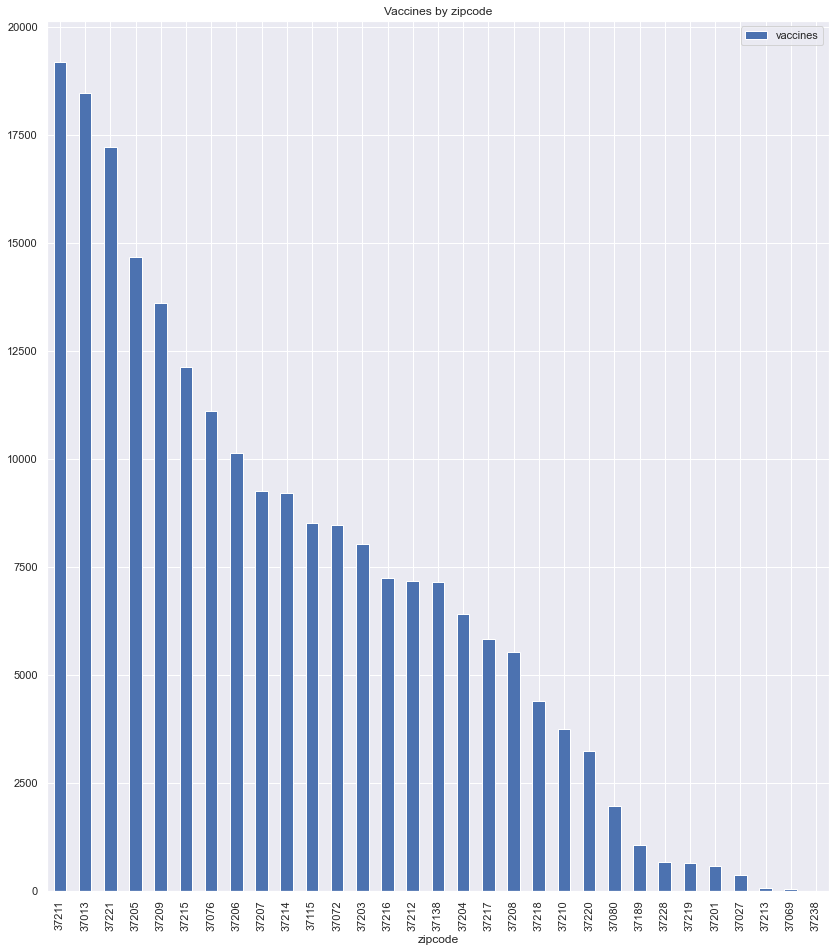

In [1786]:
Cases_Vacc.plot.bar('zipcode','vaccines')
plt.title('Vaccines by zipcode')

In [1787]:
Cases_Vacc =Cases_Vacc.sort_values('Cases', ascending=False)
Cases_Vacc.head()

,zipcode,Cases,vaccines
0,37013,13354,18465.0
18,37211,10233,19175.0
16,37209,5072,13600.0
14,37207,4729,9255.0
6,37115,4574,8520.0


Text(0.5, 1.0, 'Cases by zipcode')

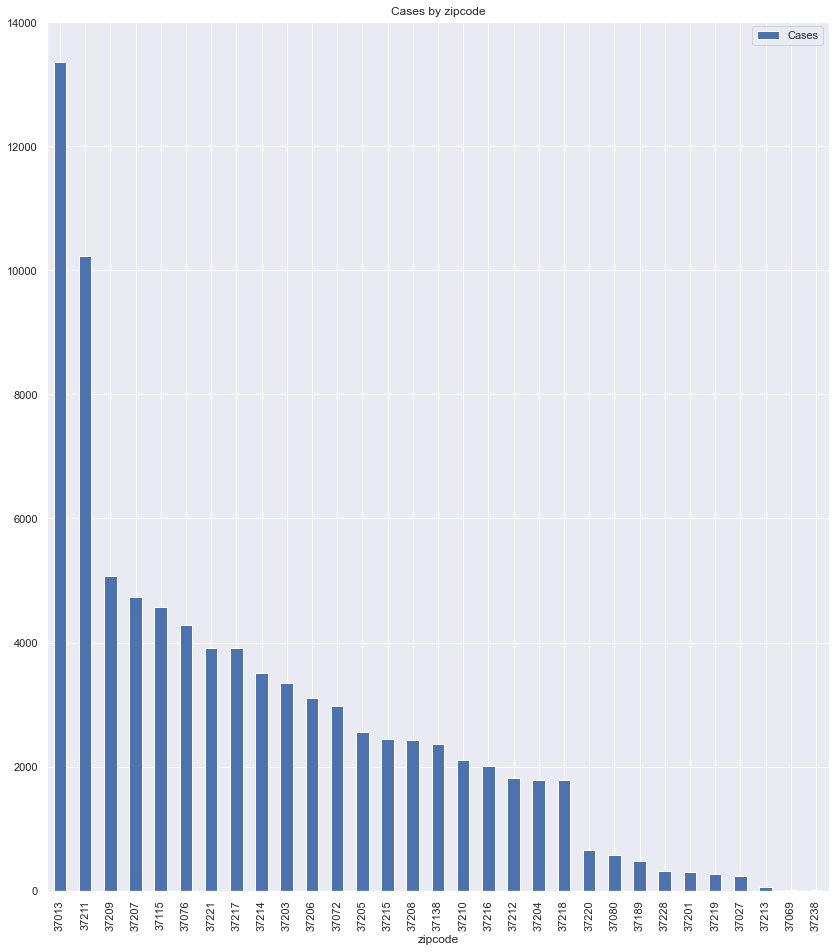

In [1788]:
Cases_Vacc.plot.bar('zipcode','Cases')
plt.title('Cases by zipcode')

In [1789]:
#Covid_df2.zipcode = Covid_df2.zipcode.astype('Int64')

In [1790]:
#Covid_df2.zipcode = Covid_df2.zipcode.astype('str')

In [1791]:
#Covid_df_top10=Covid_df2.sort_values('Cases',ascending=False)#
#Covid_df_top10

### Population data

In [1792]:
# Read the data file in Excel into the application, Skipping the header and loading sheet 0 is actual value sheet 1 = %
population_df = pd.read_excel("data/ethnicity_data.xlsx", skiprows = 1, header=[0, 1], sheet_name = 2)
#Drop columns with Error next to each of the columns
population_df = population_df[population_df.columns.drop(list(population_df.filter(regex='Error')))]
#Drop a Level of Value headers that mean nothing to the data
population_df.columns =population_df.columns.droplevel(1)
# Remove unnecessary rows that will not be part of our statistics
#Ethnicity_df1=Ethnicity_df.drop(Ethnicity_df.index[[1,9,10,12,13,14,15,16,17,18,19,20,21]])

pos = [1,9,10,12,13,14,15,16,17,18,19,20]
population_df.drop(population_df.index[pos], inplace=True)
population_df.reset_index(inplace = True)
population_df= population_df.set_index('Unnamed: 0_level_0').T.reset_index()
population_df.rename(columns = {'index':'Zipcode'}, inplace = True)
indexNames = population_df[ population_df['Zipcode'] == 'index' ].index
population_df.drop(indexNames , inplace=True)
population_df


Unnamed: 0_level_0,Zipcode,Total:,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:
1,37010,4966,4502,245,2,27,0,0,27,163
2,37012,2185,2050,73,0,3,0,0,8,51
3,37013,97939,40080,33280,95,4250,0,374,3052,16808
4,37014,2835,2682,18,0,47,0,0,36,52
5,37015,17665,15842,304,147,107,0,5,363,897
...,...,...,...,...,...,...,...,...,...,...
114,38552,157,157,0,0,0,0,0,0,0
115,38560,1405,1307,0,2,61,0,0,35,0
116,38563,3410,3202,140,0,13,0,39,16,0
117,38567,685,615,0,0,0,0,0,45,25


In [1793]:
population_df = population_df[population_df['Zipcode'] != 37213]
population_df.head()

Unnamed: 0_level_0,Zipcode,Total:,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:
1,37010,4966,4502,245,2,27,0,0,27,163
2,37012,2185,2050,73,0,3,0,0,8,51
3,37013,97939,40080,33280,95,4250,0,374,3052,16808
4,37014,2835,2682,18,0,47,0,0,36,52
5,37015,17665,15842,304,147,107,0,5,363,897


In [1794]:
#zipcodes.zip = zipcodes.zip.astype('float')

In [1795]:
population_df.reset_index()

Unnamed: 0_level_0,index,Zipcode,Total:,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:
0,1,37010,4966,4502,245,2,27,0,0,27,163
1,2,37012,2185,2050,73,0,3,0,0,8,51
2,3,37013,97939,40080,33280,95,4250,0,374,3052,16808
3,4,37014,2835,2682,18,0,47,0,0,36,52
4,5,37015,17665,15842,304,147,107,0,5,363,897
...,...,...,...,...,...,...,...,...,...,...,...
113,114,38552,157,157,0,0,0,0,0,0,0
114,115,38560,1405,1307,0,2,61,0,0,35,0
115,116,38563,3410,3202,140,0,13,0,39,16,0
116,117,38567,685,615,0,0,0,0,0,45,25


In [1796]:
#population_df.Zipcode = population_df.Zipcode.astype('float')
Cases_Vacc.zipcode=Cases_Vacc.zipcode.astype('str')

In [1797]:
#merging Covid cases, vaccines, and geo
Covid_geo = Cases_Vacc.merge(zipcodes, how="inner", left_on='zipcode',right_on='zip')

In [1798]:
Covid_geo.head()

,zipcode,Cases,vaccines,zip,objectid,shape_stlength,shape_starea,geometry
0,37013,13354,18465.0,37013,34,349164.88029162859,1150567551.5894165,"MULTIPOLYGON (((-86.66517 36.09108, -86.66526 ..."
1,37211,10233,19175.0,37211,39,290587.58467925159,602215091.79736328,"MULTIPOLYGON (((-86.75696 36.13189, -86.75693 ..."
2,37209,5072,13600.0,37209,10,310224.91345860378,1001364029.2892456,"MULTIPOLYGON (((-86.97543 36.20877, -86.97221 ..."
3,37207,4729,9255.0,37207,49,14456.130686344946,6987521.0933837891,"MULTIPOLYGON (((-86.78596 36.29097, -86.78595 ..."
4,37207,4729,9255.0,37207,48,196775.60104082408,556772811.32653809,"MULTIPOLYGON (((-86.75459 36.29021, -86.75465 ..."


In [1799]:
Covid_geo.drop_duplicates(subset='zip',inplace=True,ignore_index=True)


In [1800]:
Covid_geo.head()

,zipcode,Cases,vaccines,zip,objectid,shape_stlength,shape_starea,geometry
0,37013,13354,18465.0,37013,34,349164.88029162859,1150567551.5894165,"MULTIPOLYGON (((-86.66517 36.09108, -86.66526 ..."
1,37211,10233,19175.0,37211,39,290587.58467925159,602215091.79736328,"MULTIPOLYGON (((-86.75696 36.13189, -86.75693 ..."
2,37209,5072,13600.0,37209,10,310224.91345860378,1001364029.2892456,"MULTIPOLYGON (((-86.97543 36.20877, -86.97221 ..."
3,37207,4729,9255.0,37207,49,14456.130686344946,6987521.0933837891,"MULTIPOLYGON (((-86.78596 36.29097, -86.78595 ..."
4,37115,4574,8520.0,37115,1,178783.02488886821,596553400.57885742,"MULTIPOLYGON (((-86.68725 36.31821, -86.68722 ..."


In [1801]:
population_df.Zipcode = population_df.Zipcode.astype('str')

In [1802]:
Covid_geo_pop = Covid_geo.merge(population_df, how="inner", left_on='zip', right_on='Zipcode')
Covid_geo_pop.head()


,zipcode,Cases,vaccines,zip,objectid,shape_stlength,shape_starea,geometry,Zipcode,Total:,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:
0,37013,13354,18465.0,37013,34,349164.88029162859,1150567551.5894165,"MULTIPOLYGON (((-86.66517 36.09108, -86.66526 ...",37013,97939,40080,33280,95,4250,0,374,3052,16808
1,37211,10233,19175.0,37211,39,290587.58467925159,602215091.79736328,"MULTIPOLYGON (((-86.75696 36.13189, -86.75693 ...",37211,75955,39753,12331,225,6089,58,290,1779,15430
2,37209,5072,13600.0,37209,10,310224.91345860378,1001364029.2892456,"MULTIPOLYGON (((-86.97543 36.20877, -86.97221 ...",37209,38664,22566,9426,84,2180,68,49,1280,3011
3,37207,4729,9255.0,37207,49,14456.130686344946,6987521.0933837891,"MULTIPOLYGON (((-86.78596 36.29097, -86.78595 ...",37207,39544,8639,26258,68,360,0,122,508,3589
4,37115,4574,8520.0,37115,1,178783.02488886821,596553400.57885742,"MULTIPOLYGON (((-86.68725 36.31821, -86.68722 ...",37115,40343,16611,14469,208,538,11,296,854,7356


### Getting percent cases per population

In [1803]:
Covid_geo_pop['cases_per_pop']=Covid_geo_pop['Cases']/Covid_geo_pop['Total:']*100
Covid_geo_pop.head()

,zipcode,Cases,vaccines,zip,objectid,shape_stlength,shape_starea,geometry,Zipcode,Total:,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:,cases_per_pop
0,37013,13354,18465.0,37013,34,349164.88029162859,1150567551.5894165,"MULTIPOLYGON (((-86.66517 36.09108, -86.66526 ...",37013,97939,40080,33280,95,4250,0,374,3052,16808,13.635018
1,37211,10233,19175.0,37211,39,290587.58467925159,602215091.79736328,"MULTIPOLYGON (((-86.75696 36.13189, -86.75693 ...",37211,75955,39753,12331,225,6089,58,290,1779,15430,13.472451
2,37209,5072,13600.0,37209,10,310224.91345860378,1001364029.2892456,"MULTIPOLYGON (((-86.97543 36.20877, -86.97221 ...",37209,38664,22566,9426,84,2180,68,49,1280,3011,13.118146
3,37207,4729,9255.0,37207,49,14456.130686344946,6987521.0933837891,"MULTIPOLYGON (((-86.78596 36.29097, -86.78595 ...",37207,39544,8639,26258,68,360,0,122,508,3589,11.958831
4,37115,4574,8520.0,37115,1,178783.02488886821,596553400.57885742,"MULTIPOLYGON (((-86.68725 36.31821, -86.68722 ...",37115,40343,16611,14469,208,538,11,296,854,7356,11.337779


In [1804]:
Covid_geo_pop['vaccines_per_pop']=Covid_geo_pop['vaccines']/Covid_geo_pop['Total:']*100
Covid_geo_pop.head()

,zipcode,Cases,vaccines,zip,objectid,shape_stlength,shape_starea,geometry,Zipcode,Total:,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:,cases_per_pop,vaccines_per_pop
0,37013,13354,18465.0,37013,34,349164.88029162859,1150567551.5894165,"MULTIPOLYGON (((-86.66517 36.09108, -86.66526 ...",37013,97939,40080,33280,95,4250,0,374,3052,16808,13.635018,18.853572
1,37211,10233,19175.0,37211,39,290587.58467925159,602215091.79736328,"MULTIPOLYGON (((-86.75696 36.13189, -86.75693 ...",37211,75955,39753,12331,225,6089,58,290,1779,15430,13.472451,25.245211
2,37209,5072,13600.0,37209,10,310224.91345860378,1001364029.2892456,"MULTIPOLYGON (((-86.97543 36.20877, -86.97221 ...",37209,38664,22566,9426,84,2180,68,49,1280,3011,13.118146,35.174840
3,37207,4729,9255.0,37207,49,14456.130686344946,6987521.0933837891,"MULTIPOLYGON (((-86.78596 36.29097, -86.78595 ...",37207,39544,8639,26258,68,360,0,122,508,3589,11.958831,23.404309
4,37115,4574,8520.0,37115,1,178783.02488886821,596553400.57885742,"MULTIPOLYGON (((-86.68725 36.31821, -86.68722 ...",37115,40343,16611,14469,208,538,11,296,854,7356,11.337779,21.118905


### Drop outlier zipcode 37213

In [1805]:
#Covid_geo = Covid_geo[Covid_geo['zip']!=37213]
Covid_geo_pop_filtered = Covid_geo_pop[Covid_geo_pop['Zipcode'] != 37213]
Covid_geo_pop_filtered.head()

,zipcode,Cases,vaccines,zip,objectid,shape_stlength,shape_starea,geometry,Zipcode,Total:,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:,cases_per_pop,vaccines_per_pop
0,37013,13354,18465.0,37013,34,349164.88029162859,1150567551.5894165,"MULTIPOLYGON (((-86.66517 36.09108, -86.66526 ...",37013,97939,40080,33280,95,4250,0,374,3052,16808,13.635018,18.853572
1,37211,10233,19175.0,37211,39,290587.58467925159,602215091.79736328,"MULTIPOLYGON (((-86.75696 36.13189, -86.75693 ...",37211,75955,39753,12331,225,6089,58,290,1779,15430,13.472451,25.245211
2,37209,5072,13600.0,37209,10,310224.91345860378,1001364029.2892456,"MULTIPOLYGON (((-86.97543 36.20877, -86.97221 ...",37209,38664,22566,9426,84,2180,68,49,1280,3011,13.118146,35.174840
3,37207,4729,9255.0,37207,49,14456.130686344946,6987521.0933837891,"MULTIPOLYGON (((-86.78596 36.29097, -86.78595 ...",37207,39544,8639,26258,68,360,0,122,508,3589,11.958831,23.404309
4,37115,4574,8520.0,37115,1,178783.02488886821,596553400.57885742,"MULTIPOLYGON (((-86.68725 36.31821, -86.68722 ...",37115,40343,16611,14469,208,538,11,296,854,7356,11.337779,21.118905


In [1806]:
#Covid_geo['geometry'] = Covid_df.apply(lambda x: Point((float(x.lng), 
#                                                         float(x.lat))),  #they are already floats can take out
#                                        axis=1)

## Creating a new column to hold: Fully vaccinated or Half

In [1807]:
#V_protocol.loc[(V_protocol['dose_nbr'] == '2.0') | (V_protocol['protocol'] == 'two-shot'), 'complete'] = 'Fully'  
#V_protocol.loc[(V_protocol['dose_nbr'] == '1.0') | (V_protocol['protocol'] == 'two-shot'), 'complete'] = 'Half' 
#V_protocol.loc[(V_protocol['dose_nbr'] == '1.0') | (V_protocol['protocol'] == 'one-shot'), 'complete'] = 'Fully'
#print(V_protocol.tail(50))

# create a list of our conditions
###conditions = [
    
   ### (V_protocol['dose_nbr'] == 2.0) & (V_protocol['protocol'] == 'two-shot'),
   ### (V_protocol['dose_nbr'] == 1.0) & (V_protocol['protocol'] == 'two-shot'),
   ### (V_protocol['dose_nbr'] == 1.0) & (V_protocol['protocol'] == 'one-shot')
   # ]

# create a list of the values we want to assign for each condition
##values = ['Full', 'Half', 'Full']

# create a new column and use np.select to assign values to it using our lists as arguments
##V_protocol['Complete'] = np.select(conditions, values)

##V_protocol.tail(50)

In [1808]:
#group by zipcode
#Vaccine_df2 = V_protocol.groupby(['zipcode'],as_index=False)['count'].sum()
#Vaccine_df2

In [1809]:
#does same thing as group by zipcode
#Vaccine_df = Vaccine_df2.groupby(['zipcode', 'count_given']).size().reset_index(name="Count")
#Vaccine_df.drop('Count',axis='columns',inplace=True)
#Vaccine_df

# Ethnicity

In [1810]:
# Read the data file in Excel into the application, Skipping the header and loading sheet 0 is actual value sheet 1 = %
Ethnicity_df = pd.read_excel("data/ethnicity_data.xlsx", skiprows = 1, header=[0, 1], sheet_name = 1)
#Drop columns with Error next to each of the columns
Ethnicity_df = Ethnicity_df[Ethnicity_df.columns.drop(list(Ethnicity_df.filter(regex='Error')))]
#Drop a Level of Value headers that mean nothing to the data
Ethnicity_df.columns =Ethnicity_df.columns.droplevel(1)
# Remove unnecessary rows that will not be part of our statistics
#Ethnicity_df1=Ethnicity_df.drop(Ethnicity_df.index[[1,9,10,12,13,14,15,16,17,18,19,20,21]])

pos = [1,9,10,12,13,14,15,16,17,18,19,20,21]
Ethnicity_df.drop(Ethnicity_df.index[pos], inplace=True)

#Rotate the dataframe so that Zip can be column and the race data set across and reset the index
Ethnicity_df.reset_index(inplace = True)
Ethnicity_df= Ethnicity_df.set_index('Unnamed: 0_level_0').T.reset_index()

In [1811]:
Ethnicity_df.head()

Unnamed: 0_level_0,index,Total:,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:
0,index,0,2,3,4,5,6,7,8,11
1,37010,1.0,0.906565,0.049335,0.000403,0.005437,0.0,0.0,0.005437,0.032823
2,37012,1.0,0.938215,0.03341,0.0,0.001373,0.0,0.0,0.003661,0.023341
3,37013,1.0,0.409234,0.339803,0.00097,0.043394,0.0,0.003819,0.031162,0.171617
4,37014,1.0,0.946032,0.006349,0.0,0.016578,0.0,0.0,0.012698,0.018342


In [1812]:
population_df

Unnamed: 0_level_0,Zipcode,Total:,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:
1,37010,4966,4502,245,2,27,0,0,27,163
2,37012,2185,2050,73,0,3,0,0,8,51
3,37013,97939,40080,33280,95,4250,0,374,3052,16808
4,37014,2835,2682,18,0,47,0,0,36,52
5,37015,17665,15842,304,147,107,0,5,363,897
...,...,...,...,...,...,...,...,...,...,...
114,38552,157,157,0,0,0,0,0,0,0
115,38560,1405,1307,0,2,61,0,0,35,0
116,38563,3410,3202,140,0,13,0,39,16,0
117,38567,685,615,0,0,0,0,0,45,25


### Remove Total  and Column
### Rename index column to Zipcode 
### Remove row with 'index' for Zipcode column



In [1813]:
Ethnicity_df.drop(['Total:'], axis=1, inplace=True)
#Ethnicity_df.drop('Unnamed: 0_level_0', axis=1, inplace=True)
Ethnicity_df.columns
Ethnicity_df.head()


Unnamed: 0_level_0,index,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:
0,index,2,3,4,5,6,7,8,11
1,37010,0.906565,0.049335,0.000403,0.005437,0.0,0.0,0.005437,0.032823
2,37012,0.938215,0.03341,0.0,0.001373,0.0,0.0,0.003661,0.023341
3,37013,0.409234,0.339803,0.00097,0.043394,0.0,0.003819,0.031162,0.171617
4,37014,0.946032,0.006349,0.0,0.016578,0.0,0.0,0.012698,0.018342


In [1814]:
Ethnicity_df.rename(columns = {'index':'Zipcode'}, inplace = True)
Ethnicity_df.head()

Unnamed: 0_level_0,Zipcode,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:
0,index,2,3,4,5,6,7,8,11
1,37010,0.906565,0.049335,0.000403,0.005437,0.0,0.0,0.005437,0.032823
2,37012,0.938215,0.03341,0.0,0.001373,0.0,0.0,0.003661,0.023341
3,37013,0.409234,0.339803,0.00097,0.043394,0.0,0.003819,0.031162,0.171617
4,37014,0.946032,0.006349,0.0,0.016578,0.0,0.0,0.012698,0.018342


In [1815]:
indexNames = Ethnicity_df[ Ethnicity_df['Zipcode'] == 'index' ].index

In [1816]:
Ethnicity_df.drop(indexNames , inplace=True)
Ethnicity_df.head()

Unnamed: 0_level_0,Zipcode,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:
1,37010,0.906565,0.049335,0.000403,0.005437,0.0,0.0,0.005437,0.032823
2,37012,0.938215,0.03341,0.0,0.001373,0.0,0.0,0.003661,0.023341
3,37013,0.409234,0.339803,0.00097,0.043394,0.0,0.003819,0.031162,0.171617
4,37014,0.946032,0.006349,0.0,0.016578,0.0,0.0,0.012698,0.018342
5,37015,0.896802,0.017209,0.008322,0.006057,0.0,0.000283,0.020549,0.050778


In [1817]:
#ethnicity_top=Ethnicity_df.head(10)
#ethnicity_top
#Ethnicity_df



In [1818]:
columns = Ethnicity_df.columns
columns = columns.to_list()

In [1819]:
#columns

In [1820]:
for c in columns:
  Ethnicity_df[c] = pd.to_numeric(Ethnicity_df[c],'coerce')

In [1821]:
Covid_df2['zipcode']=  pd.to_numeric(Covid_df2['zipcode'],'coerce')

In [1822]:
#Covid_df2.info()
Ethnicity_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 1 to 118
Data columns (total 9 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Zipcode                                           118 non-null    int64  
 1   White alone                                       116 non-null    float64
 2   Black or African American alone                   116 non-null    float64
 3   American Indian and Alaska Native alone           116 non-null    float64
 4   Asian alone                                       116 non-null    float64
 5   Native Hawaiian and Other Pacific Islander alone  116 non-null    float64
 6   Some other race alone                             116 non-null    float64
 7   Two or more races:                                116 non-null    float64
 8   Hispanic or Latino:                               116 non-null    float64
dtypes: float64(8), int64(1

In [1823]:
zip_hood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   zip            30 non-null     object
 1   neighborhood   30 non-null     object
 2   neighborhood2  30 non-null     object
dtypes: object(3)
memory usage: 848.0+ bytes


### Merging ethnicity_df with zip_hood

In [1824]:
Ethnicity_df.Zipcode=Ethnicity_df.Zipcode.astype('str')

In [1825]:
Ethnicity_df.head()

Unnamed: 0_level_0,Zipcode,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:
1,37010,0.906565,0.049335,0.000403,0.005437,0.0,0.000000,0.005437,0.032823
2,37012,0.938215,0.033410,0.000000,0.001373,0.0,0.000000,0.003661,0.023341
3,37013,0.409234,0.339803,0.000970,0.043394,0.0,0.003819,0.031162,0.171617
4,37014,0.946032,0.006349,0.000000,0.016578,0.0,0.000000,0.012698,0.018342
5,37015,0.896802,0.017209,0.008322,0.006057,0.0,0.000283,0.020549,0.050778


In [1826]:
zip_hood.head()

,zip,neighborhood,neighborhood2
0,37013,Antioch,Antioch
1,37027,Brentwood,Brentwood
2,37069,Franklin,Franklin
3,37072,Goodlettesville,Goodlettesville | Parkwood
4,37076,South Hermitage,South Hermitage


In [1827]:
Ethnicity_hood=Ethnicity_df.merge(zip_hood, how='inner',left_on='Zipcode', right_on='zip')
Ethnicity_hood.head()

,Zipcode,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:,zip,neighborhood,neighborhood2
0,37013,0.409234,0.339803,0.000970,0.043394,0.000000,0.003819,0.031162,0.171617,37013,Antioch,Antioch
1,37027,0.837536,0.033662,0.000659,0.066148,0.000000,0.001354,0.019049,0.041592,37027,Brentwood,Brentwood
2,37069,0.917868,0.024674,0.000000,0.016612,0.000586,0.000000,0.025895,0.014365,37069,Franklin,Franklin
3,37072,0.754573,0.136543,0.002540,0.020037,0.000000,0.007748,0.018449,0.060111,37072,Goodlettesville,Goodlettesville | Parkwood
4,37076,0.654939,0.214785,0.001967,0.029954,0.000000,0.002216,0.019746,0.076393,37076,South Hermitage,South Hermitage


### Drop neighborhood 2

In [1828]:
Ethnicity_hood=Ethnicity_hood.drop('neighborhood2',1)
Ethnicity_hood.head()

,Zipcode,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:,zip,neighborhood
0,37013,0.409234,0.339803,0.000970,0.043394,0.000000,0.003819,0.031162,0.171617,37013,Antioch
1,37027,0.837536,0.033662,0.000659,0.066148,0.000000,0.001354,0.019049,0.041592,37027,Brentwood
2,37069,0.917868,0.024674,0.000000,0.016612,0.000586,0.000000,0.025895,0.014365,37069,Franklin
3,37072,0.754573,0.136543,0.002540,0.020037,0.000000,0.007748,0.018449,0.060111,37072,Goodlettesville
4,37076,0.654939,0.214785,0.001967,0.029954,0.000000,0.002216,0.019746,0.076393,37076,South Hermitage


In [1829]:
Ethnicity_hood.iloc[:,1:9]=Ethnicity_hood.iloc[:,1:9] *100


In [1830]:
Ethnicity_hood.head()

,Zipcode,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:,zip,neighborhood
0,37013,40.923432,33.980335,0.096999,4.339436,0.000000,0.381870,3.116225,17.161703,37013,Antioch
1,37027,83.753586,3.366181,0.065934,6.614751,0.000000,0.135431,1.904949,4.159167,37027,Brentwood
2,37069,91.786779,2.467387,0.000000,1.661211,0.058631,0.000000,2.589534,1.436459,37069,Franklin
3,37072,75.457259,13.654261,0.254033,2.003683,0.000000,0.774800,1.844913,6.011050,37072,Goodlettesville
4,37076,65.493887,21.478549,0.196708,2.995443,0.000000,0.221608,1.974552,7.639252,37076,South Hermitage


## Merging Covid cases with ethnicity--inner join 

In [1831]:
#drop 37213 outlier
Ethnicity_hood=Ethnicity_hood[Ethnicity_hood.Zipcode != '37213']
Ethnicity_hood.head()

,Zipcode,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:,zip,neighborhood
0,37013,40.923432,33.980335,0.096999,4.339436,0.000000,0.381870,3.116225,17.161703,37013,Antioch
1,37027,83.753586,3.366181,0.065934,6.614751,0.000000,0.135431,1.904949,4.159167,37027,Brentwood
2,37069,91.786779,2.467387,0.000000,1.661211,0.058631,0.000000,2.589534,1.436459,37069,Franklin
3,37072,75.457259,13.654261,0.254033,2.003683,0.000000,0.774800,1.844913,6.011050,37072,Goodlettesville
4,37076,65.493887,21.478549,0.196708,2.995443,0.000000,0.221608,1.974552,7.639252,37076,South Hermitage


In [1832]:
#Covid_geo.astype('str')

In [1833]:
Ethnicity_Cases_final=Ethnicity_hood.merge(Cases_Vacc, how='inner', left_on='Zipcode', right_on ='zipcode')
#Ethnicity_Cases_final=Ethnicity_Cases_final.style.format({'White alone': '{:.2%}'},'Black or African American alone': '{:.2%}'})
#changing to percentages 
#Ethnicity_Cases_final.iloc[:,3:]=Ethnicity_Cases_final.iloc[:,3:] *100
Ethnicity_Cases_final.head()

,Zipcode,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:,zip,neighborhood,zipcode,Cases,vaccines
0,37013,40.923432,33.980335,0.096999,4.339436,0.000000,0.381870,3.116225,17.161703,37013,Antioch,37013,13354,18465.0
1,37027,83.753586,3.366181,0.065934,6.614751,0.000000,0.135431,1.904949,4.159167,37027,Brentwood,37027,231,352.0
2,37069,91.786779,2.467387,0.000000,1.661211,0.058631,0.000000,2.589534,1.436459,37069,Franklin,37069,16,50.0
3,37072,75.457259,13.654261,0.254033,2.003683,0.000000,0.774800,1.844913,6.011050,37072,Goodlettesville,37072,2984,8460.0
4,37076,65.493887,21.478549,0.196708,2.995443,0.000000,0.221608,1.974552,7.639252,37076,South Hermitage,37076,4279,11113.0


In [1834]:
Ethnicity_final=Ethnicity_Cases_final.merge(population_df, on= 'Zipcode')
Ethnicity_final.head()

,Zipcode,White alone_x,Black or African American alone_x,American Indian and Alaska Native alone_x,Asian alone_x,Native Hawaiian and Other Pacific Islander alone_x,Some other race alone_x,Two or more races:_x,Hispanic or Latino:_x,zip,...,vaccines,Total:,White alone_y,Black or African American alone_y,American Indian and Alaska Native alone_y,Asian alone_y,Native Hawaiian and Other Pacific Islander alone_y,Some other race alone_y,Two or more races:_y,Hispanic or Latino:_y
0,37013,40.923432,33.980335,0.096999,4.339436,0.000000,0.381870,3.116225,17.161703,37013,...,18465.0,97939,40080,33280,95,4250,0,374,3052,16808
1,37027,83.753586,3.366181,0.065934,6.614751,0.000000,0.135431,1.904949,4.159167,37027,...,352.0,56117,47000,1889,37,3712,0,76,1069,2334
2,37069,91.786779,2.467387,0.000000,1.661211,0.058631,0.000000,2.589534,1.436459,37069,...,50.0,20467,18786,505,0,340,12,0,530,294
3,37072,75.457259,13.654261,0.254033,2.003683,0.000000,0.774800,1.844913,6.011050,37072,...,8460.0,31492,23763,4300,80,631,0,244,581,1893
4,37076,65.493887,21.478549,0.196708,2.995443,0.000000,0.221608,1.974552,7.639252,37076,...,11113.0,40161,26303,8626,79,1203,0,89,793,3068


In [1835]:
Ethnicity_final=Ethnicity_final.drop(['White alone_y','Black or African American alone_y','American Indian and Alaska Native alone_y','Asian alone_y','Native Hawaiian and Other Pacific Islander alone_y','Some other race alone_y','Two or more races:_y','Hispanic or Latino:_y'],axis=1)
Ethnicity_final.head()

,Zipcode,White alone_x,Black or African American alone_x,American Indian and Alaska Native alone_x,Asian alone_x,Native Hawaiian and Other Pacific Islander alone_x,Some other race alone_x,Two or more races:_x,Hispanic or Latino:_x,zip,neighborhood,zipcode,Cases,vaccines,Total:
0,37013,40.923432,33.980335,0.096999,4.339436,0.000000,0.381870,3.116225,17.161703,37013,Antioch,37013,13354,18465.0,97939
1,37027,83.753586,3.366181,0.065934,6.614751,0.000000,0.135431,1.904949,4.159167,37027,Brentwood,37027,231,352.0,56117
2,37069,91.786779,2.467387,0.000000,1.661211,0.058631,0.000000,2.589534,1.436459,37069,Franklin,37069,16,50.0,20467
3,37072,75.457259,13.654261,0.254033,2.003683,0.000000,0.774800,1.844913,6.011050,37072,Goodlettesville,37072,2984,8460.0,31492
4,37076,65.493887,21.478549,0.196708,2.995443,0.000000,0.221608,1.974552,7.639252,37076,South Hermitage,37076,4279,11113.0,40161


In [1836]:
#rename columns
Ethnicity_final=Ethnicity_final.rename(columns={'White alone_x':'White alone','Black or African American alone_x':'Black or African American alone','American Indian and Alaska Native alone_x':'American Indian and Alaska Native alone','Asian alone_x':'Asian alone','Native Hawaiian and Other Pacific Islander alone_x':'Native Hawaiian and Other Pacific Islander alone','Some other race alone_x':'Some other race alone','Two or more races:_x':'Two or more races:','Hispanic or Latino:_x':'Hispanic or Latino:'})
Ethnicity_final.head()

,Zipcode,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:,zip,neighborhood,zipcode,Cases,vaccines,Total:
0,37013,40.923432,33.980335,0.096999,4.339436,0.000000,0.381870,3.116225,17.161703,37013,Antioch,37013,13354,18465.0,97939
1,37027,83.753586,3.366181,0.065934,6.614751,0.000000,0.135431,1.904949,4.159167,37027,Brentwood,37027,231,352.0,56117
2,37069,91.786779,2.467387,0.000000,1.661211,0.058631,0.000000,2.589534,1.436459,37069,Franklin,37069,16,50.0,20467
3,37072,75.457259,13.654261,0.254033,2.003683,0.000000,0.774800,1.844913,6.011050,37072,Goodlettesville,37072,2984,8460.0,31492
4,37076,65.493887,21.478549,0.196708,2.995443,0.000000,0.221608,1.974552,7.639252,37076,South Hermitage,37076,4279,11113.0,40161


In [1837]:
Ethnicity_final=Ethnicity_final.drop(['zip','zipcode'],axis=1)
Ethnicity_final.head()

,Zipcode,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:,neighborhood,Cases,vaccines,Total:
0,37013,40.923432,33.980335,0.096999,4.339436,0.000000,0.381870,3.116225,17.161703,Antioch,13354,18465.0,97939
1,37027,83.753586,3.366181,0.065934,6.614751,0.000000,0.135431,1.904949,4.159167,Brentwood,231,352.0,56117
2,37069,91.786779,2.467387,0.000000,1.661211,0.058631,0.000000,2.589534,1.436459,Franklin,16,50.0,20467
3,37072,75.457259,13.654261,0.254033,2.003683,0.000000,0.774800,1.844913,6.011050,Goodlettesville,2984,8460.0,31492
4,37076,65.493887,21.478549,0.196708,2.995443,0.000000,0.221608,1.974552,7.639252,South Hermitage,4279,11113.0,40161


In [1838]:
##add in cases and vaccine per pop
Ethnicity_final['cases_per_pop']=Ethnicity_final['Cases']/Ethnicity_final['Total:']*100
Ethnicity_final.head()

,Zipcode,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:,neighborhood,Cases,vaccines,Total:,cases_per_pop
0,37013,40.923432,33.980335,0.096999,4.339436,0.000000,0.381870,3.116225,17.161703,Antioch,13354,18465.0,97939,13.635018
1,37027,83.753586,3.366181,0.065934,6.614751,0.000000,0.135431,1.904949,4.159167,Brentwood,231,352.0,56117,0.411640
2,37069,91.786779,2.467387,0.000000,1.661211,0.058631,0.000000,2.589534,1.436459,Franklin,16,50.0,20467,0.078175
3,37072,75.457259,13.654261,0.254033,2.003683,0.000000,0.774800,1.844913,6.011050,Goodlettesville,2984,8460.0,31492,9.475422
4,37076,65.493887,21.478549,0.196708,2.995443,0.000000,0.221608,1.974552,7.639252,South Hermitage,4279,11113.0,40161,10.654615


In [1839]:
Ethnicity_final['vacc_per_pop']=Ethnicity_final['vaccines']/Ethnicity_final['Total:']*100
Ethnicity_final.head()

,Zipcode,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:,neighborhood,Cases,vaccines,Total:,cases_per_pop,vacc_per_pop
0,37013,40.923432,33.980335,0.096999,4.339436,0.000000,0.381870,3.116225,17.161703,Antioch,13354,18465.0,97939,13.635018,18.853572
1,37027,83.753586,3.366181,0.065934,6.614751,0.000000,0.135431,1.904949,4.159167,Brentwood,231,352.0,56117,0.411640,0.627261
2,37069,91.786779,2.467387,0.000000,1.661211,0.058631,0.000000,2.589534,1.436459,Franklin,16,50.0,20467,0.078175,0.244296
3,37072,75.457259,13.654261,0.254033,2.003683,0.000000,0.774800,1.844913,6.011050,Goodlettesville,2984,8460.0,31492,9.475422,26.863965
4,37076,65.493887,21.478549,0.196708,2.995443,0.000000,0.221608,1.974552,7.639252,South Hermitage,4279,11113.0,40161,10.654615,27.671124


In [1840]:
#adding a total population field 
total_pop=Ethnicity_final['Total:'].sum()
total_pop

C:\Users\dhoza\anaconda3\envs\geospatial\lib\site-packages\IPython\core\displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


780560

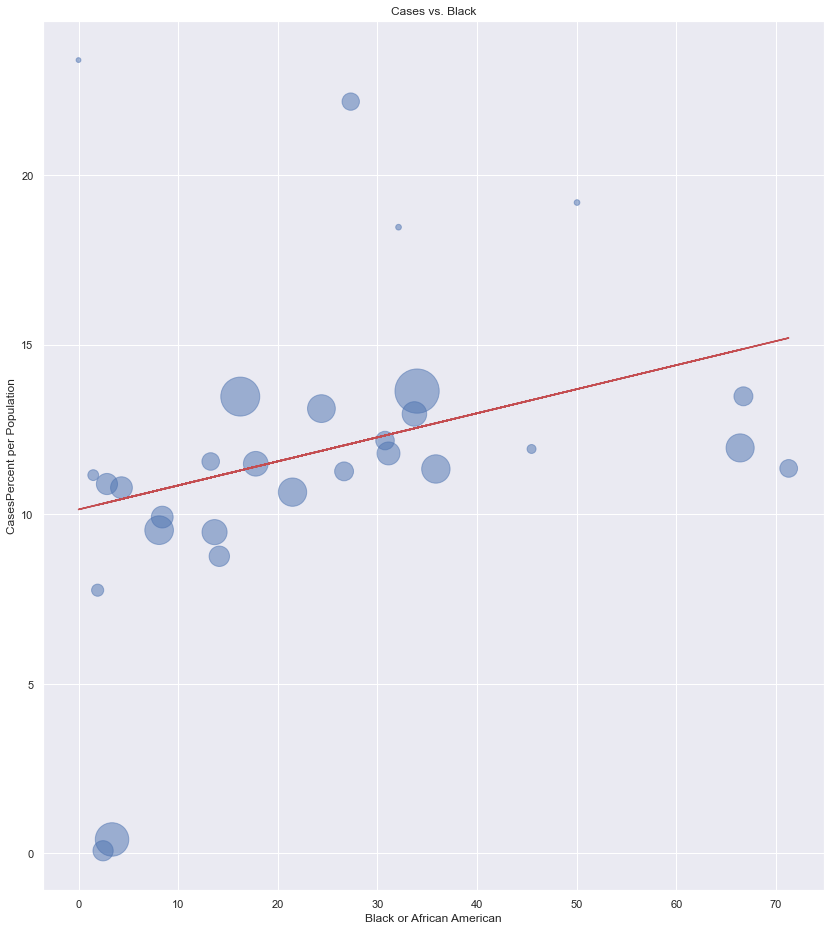

In [1841]:
a = Ethnicity_final['Total:']
plt.scatter('Black or African American alone', 'cases_per_pop', marker='o', data=Black_df, s=a/50, alpha=.5)
plt.title('Cases vs. Black')
plt.xlabel("Black or African American")
plt.ylabel('CasesPercent per Population')
x = Ethnicity_final['Black or African American alone']
y = Ethnicity_final['cases_per_pop']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")
#plt.text(80, 70, 'r = .696')
#plt.savefig('hs_grad_vs_vac.png')

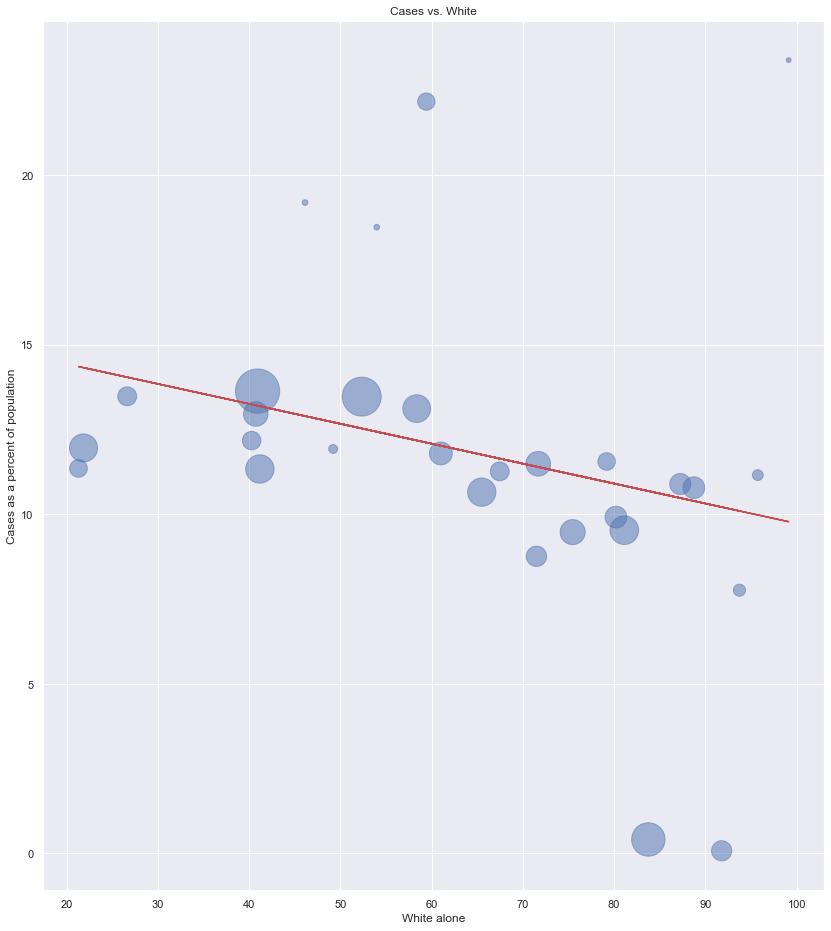

In [1842]:
a = Ethnicity_final['Total:']
plt.scatter('White alone', 'cases_per_pop', marker='o', data=Ethnicity_final, s=a/50, alpha=.5)
plt.title('Cases vs. White')
plt.xlabel("White alone")
plt.ylabel('Cases as a percent of population')
x = Ethnicity_final['White alone']
y = Ethnicity_final['cases_per_pop']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")
#plt.text(80, 70, 'r = .696')
#plt.savefig('hs_grad_vs_vac.png')

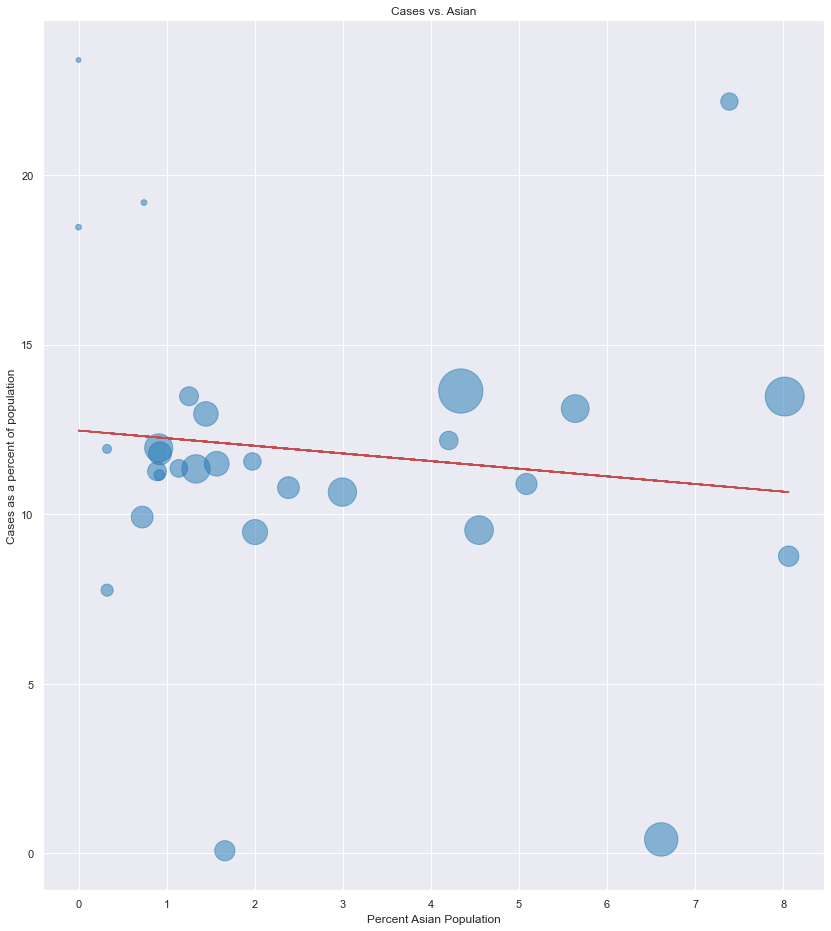

In [1862]:
a = Ethnicity_final['Total:']
plt.scatter('Asian alone', 'cases_per_pop', marker='o', data=Ethnicity_final, s=a/50, alpha=.5)
plt.title('Cases vs. Asian')
plt.xlabel("Percent Asian Population")
plt.ylabel('Cases as a percent of population')
x = Ethnicity_final['Asian alone']
y = Ethnicity_final['cases_per_pop']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")
#plt.text(80, 70, 'r = .696')
#plt.savefig('hs_grad_vs_vac.png')

In [1844]:
#chaange cases to perc of pop
#Ethnicity_Cases_final['cases_per_pop']=Ethnicity_Cases_final['Cases']/Ethnicity_Cases_final['Total:']*100


In [1863]:
Ethnicity_final.head()

,Zipcode,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:,neighborhood,Cases,vaccines,Total:,cases_per_pop,vacc_per_pop
25,37219,99.133449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.866551,Capitol Hill,270,638.0,1154,23.396880,55.285962
10,37203,59.419522,27.320920,0.079518,7.388510,0.000000,0.092771,1.696375,4.002386,Music Row,3346,8029.0,15091,22.172156,53.203896
28,37228,46.130031,50.030960,0.185759,0.743034,2.724458,0.000000,0.185759,0.000000,Metro Center,310,655.0,1615,19.195046,40.557276
9,37201,53.983941,32.118592,3.644225,0.000000,0.000000,0.000000,0.370599,9.882644,Downtown,299,576.0,1619,18.468190,35.577517
0,37013,40.923432,33.980335,0.096999,4.339436,0.000000,0.381870,3.116225,17.161703,Antioch,13354,18465.0,97939,13.635018,18.853572


In [1846]:
Ethnicity_final.sort_values('cases_per_pop',ascending=False,inplace=True)
#Ethnicity_hood=Ethnicity_hood.sort_values('Cases',ascending=False)

In [1864]:
Ethnicity_final.head()

,Zipcode,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:,neighborhood,Cases,vaccines,Total:,cases_per_pop,vacc_per_pop
25,37219,99.133449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.866551,Capitol Hill,270,638.0,1154,23.396880,55.285962
10,37203,59.419522,27.320920,0.079518,7.388510,0.000000,0.092771,1.696375,4.002386,Music Row,3346,8029.0,15091,22.172156,53.203896
28,37228,46.130031,50.030960,0.185759,0.743034,2.724458,0.000000,0.185759,0.000000,Metro Center,310,655.0,1615,19.195046,40.557276
9,37201,53.983941,32.118592,3.644225,0.000000,0.000000,0.000000,0.370599,9.882644,Downtown,299,576.0,1619,18.468190,35.577517
0,37013,40.923432,33.980335,0.096999,4.339436,0.000000,0.381870,3.116225,17.161703,Antioch,13354,18465.0,97939,13.635018,18.853572


In [1849]:
Ethnicity_final_10=Ethnicity_final.head(10)
#Ethnicity_final= Ethnicity_final.drop('zipcode', 1)
Ethnicity_final_10

,Zipcode,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:,neighborhood,Cases,vaccines,Total:,cases_per_pop,vacc_per_pop
25,37219,99.133449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.866551,Capitol Hill,270,638.0,1154,23.396880,55.285962
10,37203,59.419522,27.320920,0.079518,7.388510,0.000000,0.092771,1.696375,4.002386,Music Row,3346,8029.0,15091,22.172156,53.203896
28,37228,46.130031,50.030960,0.185759,0.743034,2.724458,0.000000,0.185759,0.000000,Metro Center,310,655.0,1615,19.195046,40.557276
9,37201,53.983941,32.118592,3.644225,0.000000,0.000000,0.000000,0.370599,9.882644,Downtown,299,576.0,1619,18.468190,35.577517
0,37013,40.923432,33.980335,0.096999,4.339436,0.000000,0.381870,3.116225,17.161703,Antioch,13354,18465.0,97939,13.635018,18.853572
15,37208,26.633724,66.731442,0.199878,1.254789,0.000000,0.127700,2.748320,2.304147,Germantown,2428,5526.0,18011,13.480651,30.681250
18,37211,52.337568,16.234613,0.296228,8.016589,0.076361,0.381805,2.342176,20.314660,Crieve Hall,10233,19175.0,75955,13.472451,25.245211
16,37209,58.364370,24.379268,0.217256,5.638320,0.175874,0.126733,3.310573,7.787606,Sylvan Park,5072,13600.0,38664,13.118146,35.174840
23,37217,40.728455,33.712599,0.524116,1.446295,0.019903,1.369999,3.025277,19.173356,South Hermitage,3907,5837.0,30146,12.960260,19.362436
17,37210,40.271336,30.762987,0.260900,4.203386,0.353664,0.121753,1.524814,22.501160,South Nashville,2100,3747.0,17248,12.175325,21.724258


In [1850]:
#dropping  columns so chart won't only pick up cases
df_nocase=Ethnicity_final_10.drop('Cases',1)
df_nocase=df_nocase.drop('vaccines',1)
df_nocase=df_nocase.drop('Total:',1)
df_nocase=df_nocase.drop('cases_per_pop',1)
df_nocase=df_nocase.drop('vacc_per_pop',1)

In [1851]:
df_nocase

,Zipcode,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:,neighborhood
25,37219,99.133449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.866551,Capitol Hill
10,37203,59.419522,27.320920,0.079518,7.388510,0.000000,0.092771,1.696375,4.002386,Music Row
28,37228,46.130031,50.030960,0.185759,0.743034,2.724458,0.000000,0.185759,0.000000,Metro Center
9,37201,53.983941,32.118592,3.644225,0.000000,0.000000,0.000000,0.370599,9.882644,Downtown
0,37013,40.923432,33.980335,0.096999,4.339436,0.000000,0.381870,3.116225,17.161703,Antioch
15,37208,26.633724,66.731442,0.199878,1.254789,0.000000,0.127700,2.748320,2.304147,Germantown
18,37211,52.337568,16.234613,0.296228,8.016589,0.076361,0.381805,2.342176,20.314660,Crieve Hall
16,37209,58.364370,24.379268,0.217256,5.638320,0.175874,0.126733,3.310573,7.787606,Sylvan Park
23,37217,40.728455,33.712599,0.524116,1.446295,0.019903,1.369999,3.025277,19.173356,South Hermitage
17,37210,40.271336,30.762987,0.260900,4.203386,0.353664,0.121753,1.524814,22.501160,South Nashville


In [1857]:
df_nocase['ziphood']=df_nocase['Zipcode']+ '\n'+ df_nocase['neighborhood']
df_nocase

,Zipcode,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races:,Hispanic or Latino:,neighborhood,ziphood
25,37219,99.133449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.866551,Capitol Hill,37219\nCapitol Hill
10,37203,59.419522,27.320920,0.079518,7.388510,0.000000,0.092771,1.696375,4.002386,Music Row,37203\nMusic Row
28,37228,46.130031,50.030960,0.185759,0.743034,2.724458,0.000000,0.185759,0.000000,Metro Center,37228\nMetro Center
9,37201,53.983941,32.118592,3.644225,0.000000,0.000000,0.000000,0.370599,9.882644,Downtown,37201\nDowntown
0,37013,40.923432,33.980335,0.096999,4.339436,0.000000,0.381870,3.116225,17.161703,Antioch,37013\nAntioch
15,37208,26.633724,66.731442,0.199878,1.254789,0.000000,0.127700,2.748320,2.304147,Germantown,37208\nGermantown
18,37211,52.337568,16.234613,0.296228,8.016589,0.076361,0.381805,2.342176,20.314660,Crieve Hall,37211\nCrieve Hall
16,37209,58.364370,24.379268,0.217256,5.638320,0.175874,0.126733,3.310573,7.787606,Sylvan Park,37209\nSylvan Park
23,37217,40.728455,33.712599,0.524116,1.446295,0.019903,1.369999,3.025277,19.173356,South Hermitage,37217\nSouth Hermitage
17,37210,40.271336,30.762987,0.260900,4.203386,0.353664,0.121753,1.524814,22.501160,South Nashville,37210\nSouth Nashville


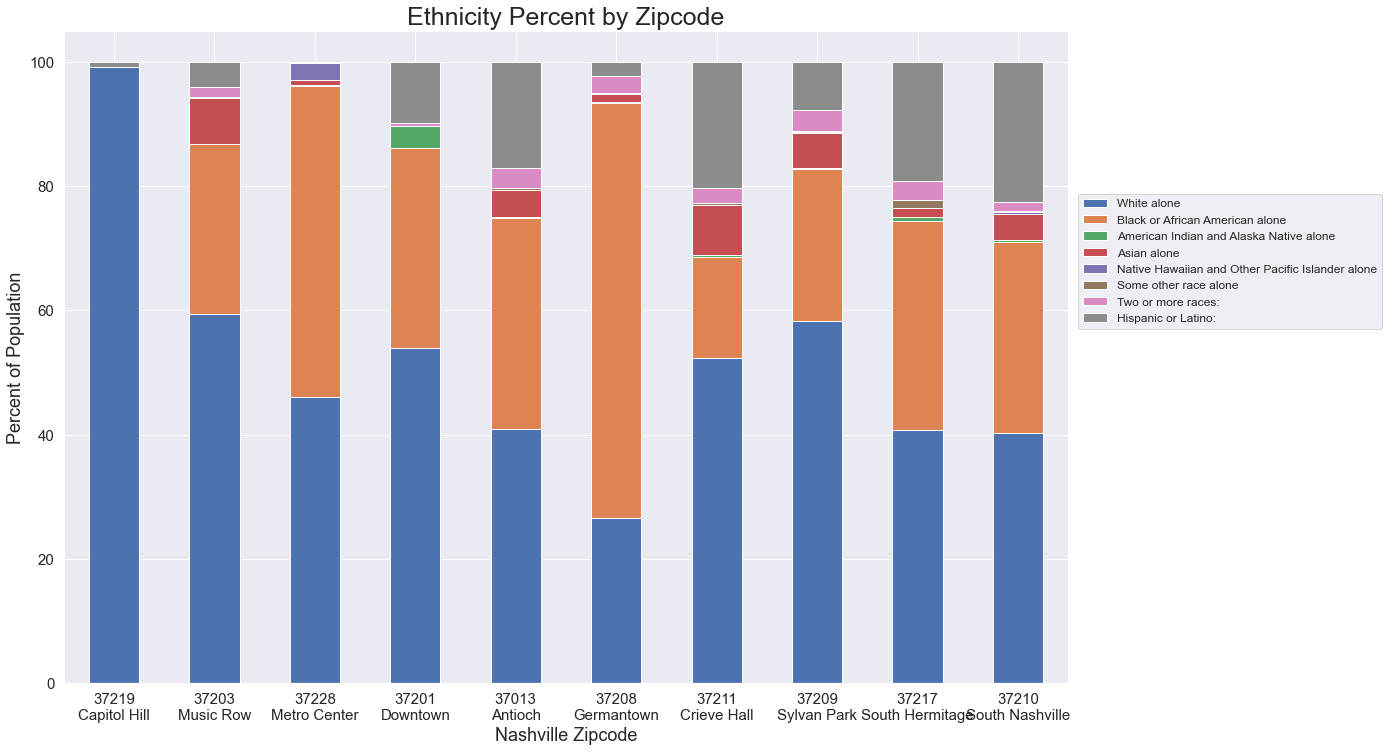

In [1860]:
sns.set()
#sns.set_palette("tab10")
sns.set_context({"figure.figsize":(18,12)})

df_nocase.set_index('ziphood').plot(kind='bar',stacked=True)
plt.title('Ethnicity Percent by Zipcode', size=25)
plt.xlabel('Nashville Zipcode', size=18)
plt.ylabel('Percent of Population',size=18)
plt.xticks(fontsize=15,rotation=0)
plt.yticks(fontsize=15)
#plt.legend(loc='lower right')
plt.legend(bbox_to_anchor=(1.01,0.75), loc=2, prop={'size':12},borderaxespad=0.)
plt.savefig('Population_ethnicity_bar_chart.png',transparent=True)

#plt.legend(prop={"size":20})
#sns.set_context({"figure.figsize": (14, 16)})
#df_nocase = df_nocase.style.format({'perc': “{:.2%}”})


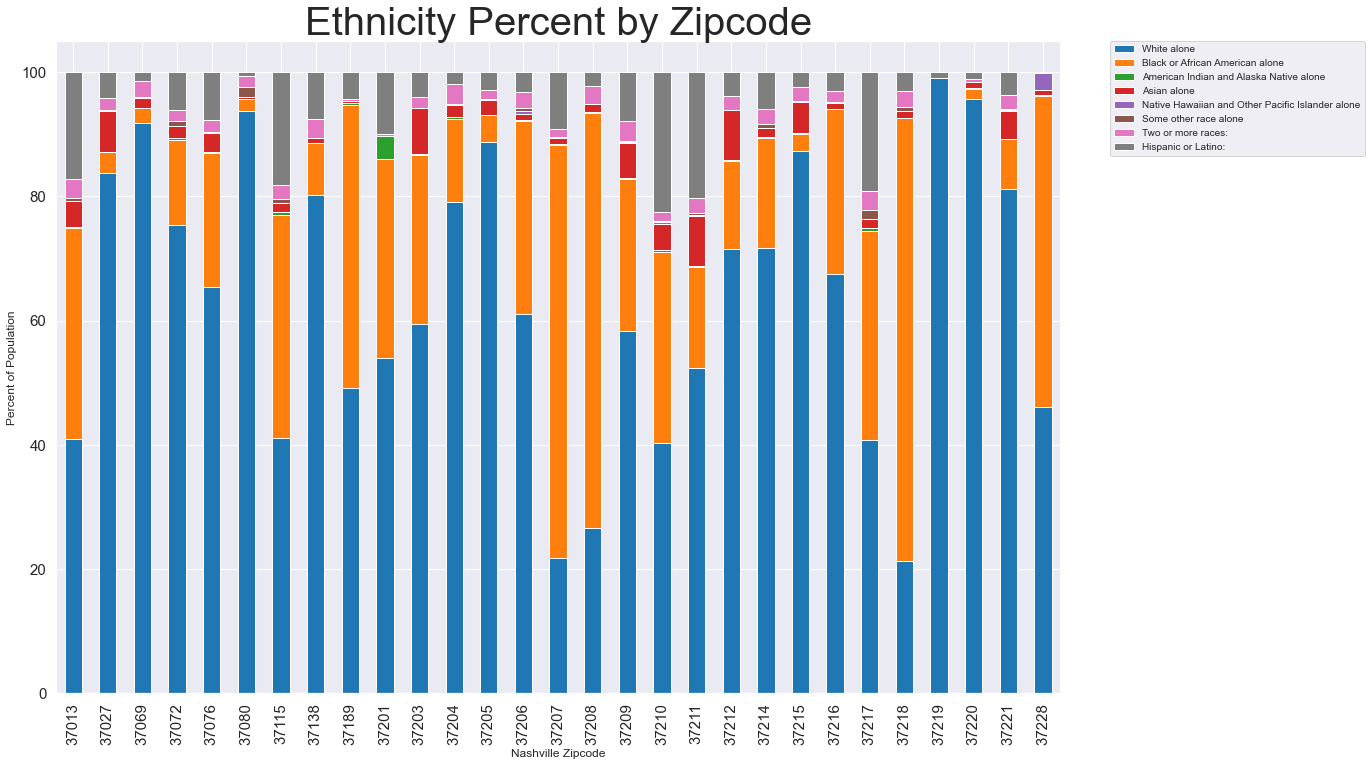

In [1861]:
sns.set()
sns.set_palette("tab10")
#savefig(fname, dpi=None, facecolor='w', edgecolor='w',
        #orientation='portrait', papertype=None, format=None,
        #transparent=False, bbox_inches=None, pad_inches=0.1,
        #frameon=None, metadata=None)
Ethnicity_hood.set_index('Zipcode','neighborhood').plot(kind='bar',stacked=True)
plt.title('Ethnicity Percent by Zipcode', size=40)
plt.xlabel('Nashville Zipcode', size=12)
plt.ylabel('Percent of Population',size=12)
#plt.legend(loc='lower right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':10},borderaxespad=0.)
#plt.legend(prop={"size":20})
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


sns.set_context({"figure.figsize": (14, 16)})
#df_nocase = df_nocase.style.format({'perc': “{:.2%}”})


# Merging Vaccine with zipcodes

In [ ]:
#merging vaccine with zipcodes(a geodataframe)
#V_zipcodes = pd.merge(left = zipcodes, right = Vaccine_df, 
                    left_on = 'zip', right_on = 'zipcode')

#V_zipcodes.drop('po_name',axis='columns',inplace=True)          below works same in less lines
#V_zipcodes.drop('objectid',axis='columns',inplace=True)
#V_zipcodes.drop('zipcode',axis='columns',inplace=True)
#V_zipcodes.head(50)

#V_zipcodes = V_zipcodes[['zip', 'shape_stlength', 'shape_starea', 'geometry', 'count_given']]
#V_zipcodes.head(50)

# vaccine count and zipcode --getting rid of duplicates

In [ ]:
##drop duplicates based on zip column
#V_zipcodes = V_zipcodes.drop_duplicates(subset=['zip'])
#V_zipcodes

In [ ]:
#fig, ax = plt.subplots(figsize=(20,10))
#V_zipcodes.plot(column = 'count_given', 
#              cmap = 'GnBu', 
#              edgecolor = 'black', 
#              ax = ax,
#              legend = True)
#ax.axis('off');
